## Hyperoxia and Organ Dysfunction
## C.V. Cosgriff for Team 11
## II MIT-HIAE Datathon

The overall goal is to assess the association between hyperoxia in the first 24 hours of mechanical ventilation and markers of organ dysfunction which, for this event, will be $\Delta$SOFA.

We will start by extracting out the base ICU cohort and then identifying the `itemid` that correspond to $SpO_2$ values.

__TODO:__ Change how SOFA day 1 and 2 are pulled in using the pivoted tables.

## 0 - Envrionment

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import psycopg2
dbname = 'mimic'
schema_name = 'mimiciii'
db_schema = 'SET search_path TO {0};'.format(schema_name)
con = psycopg2.connect(database=dbname)

## 1 - Cohort Extraction

A lot of the desired concepts already exist from previous work either directly in the database or via materialized views. We will extract as much as we can this way.

In [2]:
query = db_schema + '''
-- note that this code uses a lot of local materialized veiws
-- the SQL queries for this will be loaded on the repository
-- and the views need to be built


-- TODO: combine this queries into one ventilator parameters query
--       as this is just a sloppy way with copy and pasting.

WITH tidal_volume_24h AS(
    WITH tidal_volume AS (
        SELECT ce.icustay_id, ce.charttime - ie.intime AS offset
        , ce.valuenum
        FROM icustays ie
        LEFT JOIN chartevents ce
            ON ie.icustay_id = ce.icustay_id
        WHERE ce.itemid = 224685
    )
    SELECT tv.icustay_id, MAX(tv.valuenum) AS tv_max_24h
    FROM tidal_volume tv
    WHERE tv.offset <= interval '24' hour
    GROUP BY tv.icustay_id
)
, peep_24h AS (
    WITH peep AS (
        SELECT ce.icustay_id, ce.charttime - ie.intime AS offset
        , ce.valuenum
        FROM icustays ie
        LEFT JOIN chartevents ce
            ON ie.icustay_id = ce.icustay_id
        WHERE ce.itemid = 220339
    )
    SELECT peep.icustay_id, MAX(peep.valuenum) AS peep_max_24h
    FROM peep
    WHERE peep.offset <= interval '24' hour
    GROUP BY peep.icustay_id
)
, fio2_24h AS(
    WITH fio2 AS (
        SELECT ce.icustay_id, ce.charttime - ie.intime AS offset
        , ce.valuenum
        FROM icustays ie
        LEFT JOIN chartevents ce
            ON ie.icustay_id = ce.icustay_id
        WHERE ce.itemid = 223835
    )
    SELECT fio2.icustay_id, MAX(fio2.valuenum) AS fio2_max_24h
    FROM fio2
    WHERE fio2.offset <= interval '24' hour
    GROUP BY fio2.icustay_id
)

SELECT ie.icustay_id, ie.hadm_id, ie.subject_id, ie.dbsource
       , ie.first_careunit, ie.intime, ie.outtime, ie.los
       , ied.admission_age, ied.gender, ied.ethnicity, v.resprate_max
       , tv.tv_max_24h, pp.peep_max_24h, fi.fio2_max_24h -- vent paramaters
       , ied.first_icu_stay, oa.oasis AS oasis_score
       , s1.sofa AS sofa_day1, s2.sofa AS sofa_day2
       , elixdx.congestive_heart_failure, elixdx.cardiac_arrhythmias --- start of comorbidities
       , elixdx.valvular_disease, elixdx.pulmonary_circulation
       , elixdx.peripheral_vascular, elixdx.hypertension
       , elixdx.paralysis, elixdx.other_neurological
       , elixdx.chronic_pulmonary, elixdx.diabetes_uncomplicated
       , elixdx.diabetes_complicated, elixdx.hypothyroidism
       , elixdx.renal_failure, elixdx.liver_disease
       , elixdx.peptic_ulcer, elixdx.aids
       , elixdx.lymphoma, elixdx.metastatic_cancer
       , elixdx.solid_tumor, elixdx.rheumatoid_arthritis
       , elixdx.coagulopathy, elixdx.obesity
       , elixdx.weight_loss, elixdx.fluid_electrolyte
       , elixdx.blood_loss_anemia, elixdx.deficiency_anemias
       , elixdx.alcohol_abuse, elixdx.drug_abuse
       , elixdx.psychoses, elixdx.depression -- end of comorbidities
       , elixscore.elixhauser_vanwalraven AS elixhauser_score -- score for comorbid
       , vd.starttime AS vent_start, vd.endtime AS vent_end
       , vd.duration_hours AS ventduration, ad.hospital_expire_flag
FROM icustays ie
LEFT JOIN icustay_detail ied
    ON ie.icustay_id = ied.icustay_id
LEFT JOIN admissions ad
    ON ie.hadm_id = ad.hadm_id
LEFT JOIN vitalsfirstday v
    ON ie.icustay_id = v.icustay_id
LEFT JOIN tidal_volume_24h tv
    ON ie.icustay_id = tv.icustay_id
LEFT JOIN peep_24h pp
    ON ie.icustay_id = pp.icustay_id
LEFT JOIN fio2_24h fi
    ON ie.icustay_id = fi.icustay_id
LEFT JOIN elixhauser_ahrq_score elixscore
    ON ie.hadm_id = elixscore.hadm_id
LEFT JOIN elixhauser_ahrq_no_drg_all_icd elixdx
    ON ie.hadm_id = elixdx.hadm_id
LEFT JOIN oasis oa
    ON ie.icustay_id = oa.icustay_id
LEFT JOIN sofa_firstday s1
    ON ie.icustay_id = s1.icustay_id
LEFT JOIN sofa_secondday s2
    ON ie.icustay_id = s2.icustay_id
LEFT JOIN ventdurations vd
    ON ie.icustay_id = vd.icustay_id
    AND vd.ventnum = 1 -- we only take first vent period because we only care about first 24 hour
WHERE ie.dbsource = 'metavision';
'''
cohort_df = pd.read_sql(query, con)
print(cohort_df.shape)
display(cohort_df.head())

(23620, 54)


,icustay_id,hadm_id,subject_id,dbsource,first_careunit,intime,outtime,los,admission_age,gender,...,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression,elixhauser_score,vent_start,vent_end,ventduration,hospital_expire_flag
0,275225,100001,58526,metavision,MICU,2117-09-11 11:47:35,2117-09-15 17:57:14,4.2567,35.4765,F,...,0,0,0,0,0,5,NaT,NaT,NaN,0
1,209281,100003,54610,metavision,MICU,2150-04-17 15:35:42,2150-04-19 14:12:52,1.9425,59.9127,M,...,0,0,0,0,0,11,NaT,NaT,NaN,0
2,253656,100009,533,metavision,CSRU,2162-05-17 10:18:31,2162-05-19 22:05:14,2.4908,60.7971,M,...,1,0,0,0,0,-4,2162-05-17 18:00:00,2162-05-17 22:45:00,4.75,0
3,271147,100010,55853,metavision,SICU,2109-12-10 21:58:01,2109-12-12 12:13:20,1.5940,54.5208,F,...,0,0,0,0,0,17,NaT,NaT,NaN,0
4,214619,100011,87977,metavision,TSICU,2177-08-29 04:52:21,2177-09-09 16:56:35,11.5029,21.5041,M,...,0,0,1,0,0,-7,2177-08-29 05:00:00,2177-09-07 03:00:00,214.00,0


We'll do a quick missingness check for sanity.

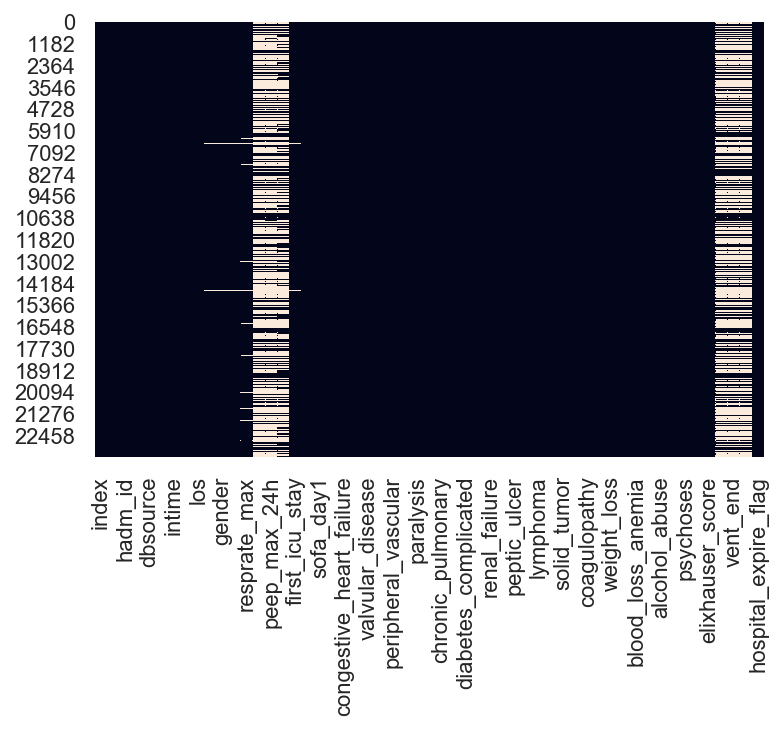

In [3]:
sns.heatmap(cohort_df.reset_index().isna(), cbar=False)

This pattern of missingness seems reasonable; patients missing vent start/end are missing vent parameters because they likely weren't on the ventilator.

## 2 - Extracting $SpO_2$ and Feature Engineering Hyperoxic Time

We start by identifying the metavision ID for $SpO_2$.

In [4]:
query = db_schema + '''
SELECT itemid, label, dbsource, linksto 
FROM d_items 
WHERE LOWER(label) LIKE '%o2%'
AND dbsource='metavision';
'''

d_search = pd.read_sql_query(query, con)
display(d_search)

,itemid,label,dbsource,linksto
0,228640,EtCO2,metavision,chartevents
1,228641,EtCO2 Clinical indication,metavision,chartevents
2,227060,Use A-aDO2,metavision,chartevents
3,227287,O2 Flow (additional cannula),metavision,chartevents
4,226860,RA %O2 Saturation (PA Line),metavision,chartevents
5,226861,ART %O2 saturation (PA Line),metavision,chartevents
6,226862,PA %O2 Saturation (PA Line),metavision,chartevents
7,226863,PVR %O2 Saturation (PA Line),metavision,chartevents
8,226865,SVR %O2 Saturation (PA Line),metavision,chartevents
9,226983,Apache IV A-aDO2,metavision,chartevents


It is `itemid` 2202777. We then extract all of these values from `chartevents` in the interval [0, 24h].

In [5]:
query = db_schema + '''
WITH spo2_day1 AS (
    SELECT ce.icustay_id, ce.charttime - ie.intime AS offset
    , ce.value
    FROM icustays ie
    LEFT JOIN chartevents ce
        ON ie.icustay_id = ce.icustay_id
    WHERE ce.itemid = 220277
)
SELECT sp.icustay_id, sp.value AS spo2_24h, sp.offset
FROM spo2_day1 sp
WHERE sp.offset <= interval '24' hour
AND sp.offset >= interval '0' hour
ORDER BY sp.offset ASC;
'''

sp_df = pd.read_sql(query, con)
display(sp_df.head())

,icustay_id,spo2_24h,offset
0,269515,100,0 days
1,261355,91,0 days
2,282785,97,0 days
3,253466,100,0 days
4,232470,100,0 days


After which we do some brief data cleaning.

In [6]:
sp_df.spo2_24h = sp_df.spo2_24h.astype(float)
sp_df = sp_df.loc[sp_df.spo2_24h <= 100, :]

We can visualize an example $SpO_2$ trend.

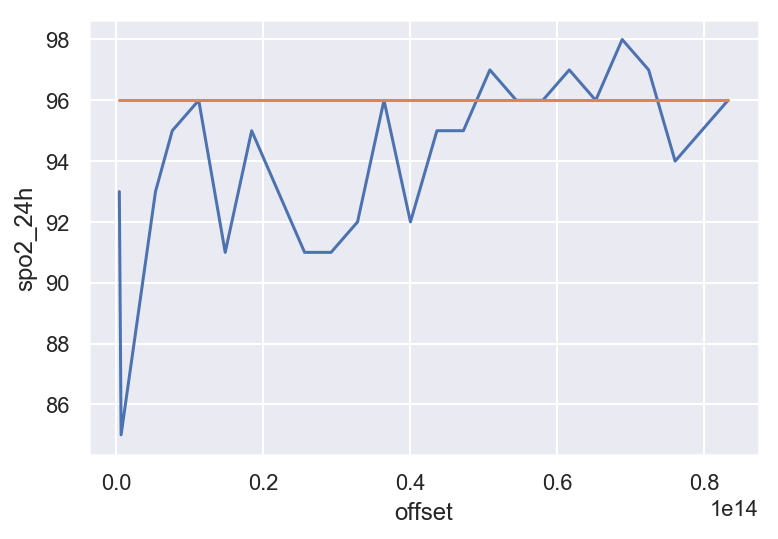

In [7]:
example_patient = sp_df.loc[sp_df.icustay_id == 241249, :].copy()
example_patient.loc[:, 'offset'] = example_patient.offset / np.timedelta64(1, 'ns')
example_patient.loc[:, 'spo2_24h'] = example_patient.spo2_24h.astype(float)
sns.lineplot(x=example_patient.offset, y=example_patient.spo2_24h)
sns.lineplot(x=[example_patient.offset.min(), example_patient.offset.max()], y=[96,96])
plt.savefig('example1.png')

We will want to integrate the peaks above the line designating normoxia; we can visualize this first.

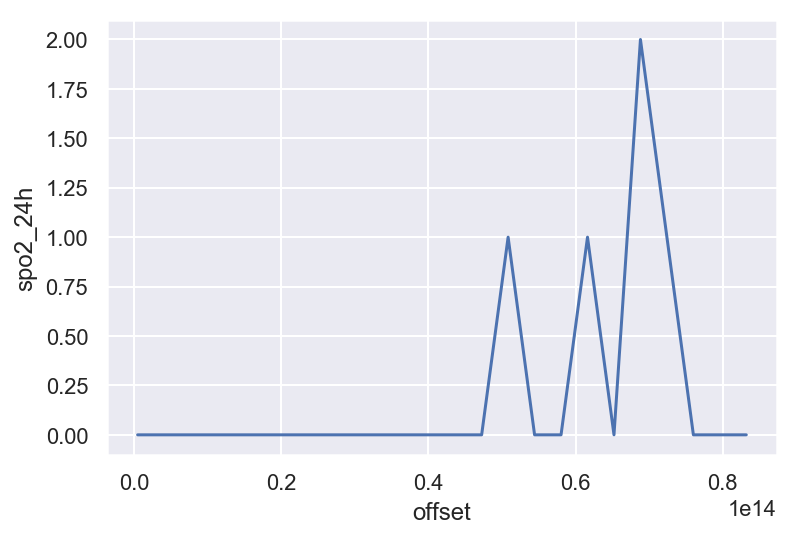

In [8]:
example_patient.loc[:, 'spo2_24h'] = example_patient.spo2_24h - 96
example_patient.loc[example_patient.spo2_24h < 0, 'spo2_24h'] = 0
sns.lineplot(x=example_patient.offset, y=example_patient.spo2_24h)
plt.savefig('example2.png')

We will write a function to integrate the area under these peaks for each patient.

In [9]:
def hyperoxic_time(time, spo2):
    spo2 = spo2 - 96
    spo2[spo2 < 0] = 0
    if (spo2 > 0).any():
        return np.trapz(y=spo2, x=time) / np.timedelta64(1, 'ns')
    else:
        return 0
    
hyperoxia_24h = [(i, hyperoxic_time(sp_df.loc[sp_df.icustay_id == i, 'offset'], sp_df.loc[sp_df.icustay_id == i, 'spo2_24h']))\
                   for i in sp_df.icustay_id.unique()]

hyperoxia_24h = pd.DataFrame(hyperoxia_24h)
hyperoxia_24h = hyperoxia_24h.rename({0 : 'icustay_id', 1 : 'hyperoxia_24h'}, axis=1)

hyperoxia_24h.head()

,icustay_id,hyperoxia_24h
0,269515,2.532600e+14
1,261355,4.002000e+13
2,282785,1.609500e+14
3,253466,1.834200e+14
4,232470,8.835000e+13


We then visualize the distribution of hyperoxic time in the first 24 hours to see if the result seems reasonable.

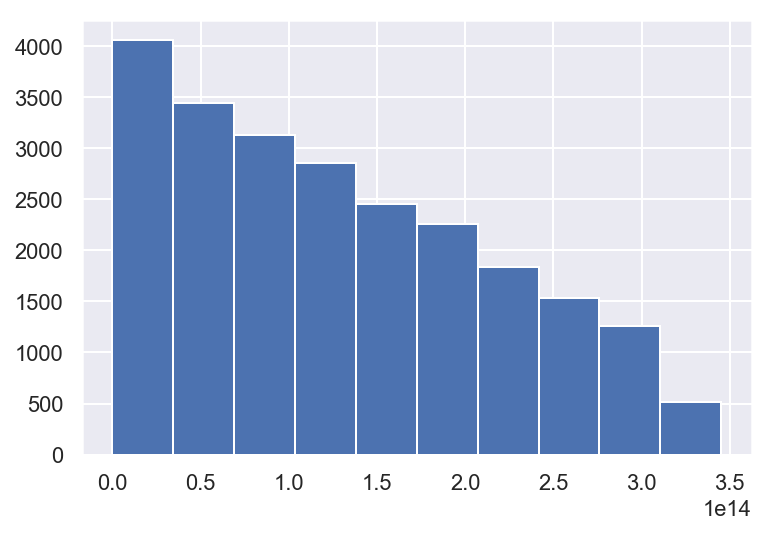

In [10]:
hyperoxia_24h.hyperoxia_24h.hist()

This looks how we would expect. The next steps are joining this feature to the base cohort, cleaning, exploration, and ultimately model building.